Model selection is the task of selecting a statistical model from a set of candidate models, given data. In the simplest cases, a pre-existing set of data is considered. Given candidate models of similar predictive or explanatory power, the simplest model is most likely to be the best choice.

The data is available in Google BigQuery that can be downloaded from here. The data is also publicly available at this Cloud Storage URL: https://storage.googleapis.com/tensorflow-workshop-examples/stack-overflow-data.csv.

In [2]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup

%matplotlib inline

In [3]:
df = pd.read_csv('stack-overflow-data.csv')
df = df[pd.notnull(df['tags'])]
df.head(10)

,post,tags
0,what is causing this behavior in our c# datet...,c#
1,have dynamic html load as if it was in an ifra...,asp.net
2,how to convert a float value in to min:sec i ...,objective-c
3,.net framework 4 redistributable just wonderi...,.net
4,trying to calculate and print the mean and its...,python
5,how to give alias name for my website i have ...,asp.net
6,window.open() returns null in angularjs it wo...,angularjs
7,identifying server timeout quickly in iphone ...,iphone
8,unknown method key error in rails 2.3.8 unit ...,ruby-on-rails
9,from the include how to show and hide the con...,angularjs


In [4]:
df['post'].apply(lambda x: len(x.split(' '))).sum()

10276752

We have over 10 million words in the data.

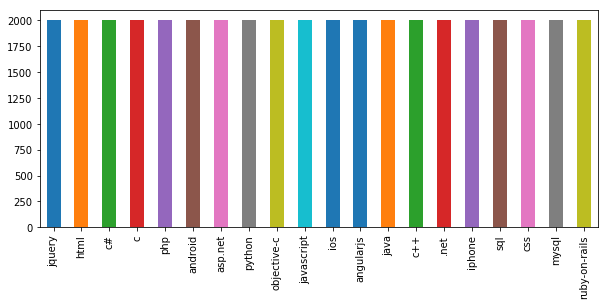

In [5]:
my_tags = ['java','html','asp.net','c#','ruby-on-rails','jquery','mysql','php','ios','javascript','python','c','css','android','iphone','sql','objective-c','c++','angularjs','.net']
plt.figure(figsize=(10,4))
df.tags.value_counts().plot(kind='bar');

The classes are very well balanced.

In [6]:
def print_plot(index):
    example = df[df.index == index][['post', 'tags']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Tag:', example[1])

Have a look a few post and tag pairs.

In [7]:
print_plot(10)

when we need interface c# <blockquote>    <strong>possible duplicate:</strong><br>   <a href= https://stackoverflow.com/questions/240152/why-would-i-want-to-use-interfaces >why would i want to use interfaces </a>   <a href= https://stackoverflow.com/questions/9451868/why-i-need-interface >why i need interface </a>    </blockquote>     i want to know where and when to use it     for example    <pre><code>interface idemo {  // function prototype  public void show(); }  // first class using the interface class myclass1 : idemo {  public void show()  {   // function body comes here   response.write( i m in myclass );  }  }  // second class using the interface class myclass2 : idemo {  public void show()   {   // function body comes here   response.write( i m in myclass2 );   response.write( so  what  );  } </code></pre>   these two classes has the same function name with different body. this can be even achieved without interface. then why we need an interface where and when to use it
Tag:

In [8]:
print_plot(30)

how to chain expressions inside ngclass when using the {...}[] form  how can i add another expression to an <code>ng-class</code> directive that uses this form:   <pre><code>ng-class= {true: loading   false: loading-done }[data.loader===null]  </code></pre>   i d like to add something like this to the list:   <pre><code>{highlight:isspecial} </code></pre>   is it possible without expanding the first expression     thanks.
Tag: angularjs


The text need to be cleaned up.

In [9]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

In [10]:
df['post'] = df['post'].apply(clean_text)

In [11]:
print_plot(10)

need interface c# possible duplicate would want use interfaces need interface want know use example interface idemo function prototype public void show first class using interface class myclass1 idemo public void show function body comes responsewrite myclass second class using interface class myclass2 idemo public void show function body comes responsewrite myclass2 responsewrite two classes function name different body even achieved without interface need interface use
Tag: c#


Way better!

In [12]:
df['post'].apply(lambda x: len(x.split(' '))).sum()

3421180

Now we have over 3 million words to work with.

In [13]:
X = df.post
y = df.tags
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

The next steps includes feature engineering. We will convert our text documents to a matrix of token counts (CountVectorizer), then transform a count matrix to a normalized tf-idf representation (tf-idf transformer). After that, we train several classifiers. 

### Naive Bayes classifier for multinomial models

In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [33]:
%%time
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.7395
               precision    recall  f1-score   support

         java       0.63      0.65      0.64       613
         html       0.94      0.86      0.90       620
      asp.net       0.87      0.92      0.90       587
           c#       0.70      0.77      0.73       586
ruby-on-rails       0.73      0.87      0.79       599
       jquery       0.72      0.51      0.60       589
        mysql       0.77      0.74      0.75       594
          php       0.69      0.89      0.78       610
          ios       0.63      0.59      0.61       617
   javascript       0.57      0.65      0.61       587
       python       0.70      0.50      0.59       611
            c       0.79      0.79      0.79       594
          css       0.84      0.59      0.69       619
      android       0.66      0.84      0.74       574
       iphone       0.64      0.83      0.72       584
          sql       0.66      0.64      0.65       578
  objective-c       0.79      0.77      0.78    

### Linear support vector machine

In [34]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False))])

In [35]:
%%time

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.7891666666666667
               precision    recall  f1-score   support

         java       0.74      0.68      0.71       613
         html       0.85      0.93      0.89       620
      asp.net       0.87      0.95      0.91       587
           c#       0.81      0.80      0.80       586
ruby-on-rails       0.74      0.88      0.80       599
       jquery       0.77      0.41      0.53       589
        mysql       0.82      0.68      0.74       594
          php       0.70      0.95      0.81       610
          ios       0.82      0.56      0.66       617
   javascript       0.72      0.59      0.65       587
       python       0.71      0.65      0.68       611
            c       0.81      0.87      0.84       594
          css       0.77      0.79      0.78       619
      android       0.83      0.86      0.85       574
       iphone       0.81      0.80      0.81       584
          sql       0.71      0.68      0.69       578
  objective-c       0.81      0.90  

### Logistic regression

In [36]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [37]:
%%time

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.783
               precision    recall  f1-score   support

         java       0.70      0.62      0.66       613
         html       0.91      0.91      0.91       620
      asp.net       0.97      0.94      0.95       587
           c#       0.78      0.77      0.78       586
ruby-on-rails       0.77      0.81      0.79       599
       jquery       0.59      0.58      0.58       589
        mysql       0.77      0.76      0.76       594
          php       0.82      0.86      0.84       610
          ios       0.70      0.72      0.71       617
   javascript       0.61      0.59      0.60       587
       python       0.64      0.63      0.64       611
            c       0.83      0.83      0.83       594
          css       0.78      0.78      0.78       619
      android       0.85      0.85      0.85       574
       iphone       0.80      0.83      0.81       584
          sql       0.65      0.65      0.65       578
  objective-c       0.82      0.84      0.83     

### Word2vec embedding and Logistic Regression

In [14]:
%%time
from gensim.models import Word2Vec

wv = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)

Wall time: 2min 11s


In [15]:
from itertools import islice
list(islice(wv.vocab, 13030, 13050))

['Memorial_Hospital',
 'Seniors',
 'memorandum',
 'elephant',
 'Trump',
 'Census',
 'pilgrims',
 'De',
 'Dogs',
 '###-####_ext',
 'chaotic',
 'forgive',
 'scholar',
 'Lottery',
 'decreasing',
 'Supervisor',
 'fundamentally',
 'Fitness',
 'abundance',
 'Hold']

The common way is to average the two word vectors. BOW based approaches which includes averaging.

In [24]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [25]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

In [26]:
train, test = train_test_split(df, test_size=0.3, random_state = 42)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['post']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['post']), axis=1).values

In [27]:
X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

C:\Users\SusanLi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
  


Wall time: 15.8 s


In [29]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(X_train_word_average, train['tags'])
y_pred = logreg.predict(X_test_word_average)

Wall time: 1min 7s


In [31]:
print('accuracy %s' % accuracy_score(y_pred, test.tags))
print(classification_report(test.tags, y_pred,target_names=my_tags))

accuracy 0.6379166666666667
               precision    recall  f1-score   support

         java       0.63      0.59      0.61       613
         html       0.73      0.76      0.75       620
      asp.net       0.65      0.67      0.66       587
           c#       0.53      0.52      0.52       586
ruby-on-rails       0.70      0.77      0.73       599
       jquery       0.44      0.39      0.41       589
        mysql       0.65      0.61      0.63       594
          php       0.73      0.80      0.76       610
          ios       0.60      0.61      0.61       617
   javascript       0.56      0.52      0.54       587
       python       0.55      0.50      0.52       611
            c       0.61      0.61      0.61       594
          css       0.65      0.65      0.65       619
      android       0.60      0.57      0.59       574
       iphone       0.70      0.71      0.71       584
          sql       0.42      0.42      0.42       578
  objective-c       0.68      0.71  

### Doc2vec and Logistic Regression

Doc2vec, taking the linear combination of every term in the document creates a random walk with bias process in the word2vec space.

In [104]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re

In [105]:
def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(doc2vec.TaggedDocument(v.split(), [label]))
    return labeled

In [106]:
X_train, X_test, y_train, y_test = train_test_split(df.post, df.tags, random_state=0, test_size=0.3)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [108]:
all_data[:2]

[TaggedDocument(words=['fulltext', 'search', 'php', 'pdo', 'returning', 'result', 'searched', 'lot', 'matter', 'find', 'wrong', 'setup', 'trying', 'fulltext', 'search', 'using', 'pdo', 'php', 'get', 'results', 'error', 'messages', 'table', 'contains', 'customer', 'details', 'id', 'int', '11', 'auto_increment', 'name', 'varchar', '150', 'lastname', 'varchar', '150', 'company', 'varchar', '250', 'adress', 'varchar', '150', 'postcode', 'int', '5', 'city', 'varchar', '150', 'email', 'varchar', '250', 'phone', 'varchar', '20', 'orgnr', 'varchar', '15', 'timestamp', 'timestamp', 'current_timestamp', 'run', 'sqlquery', 'alter', 'table', 'system_customer', 'add', 'fulltext', 'name', 'lastname', 'except', 'columns', 'id', 'postcode', 'timestamp', 'signs', 'trouble', 'far', 'idea', 'problem', 'lies', 'db', 'configuration', 'php', 'code', 'goes', 'php', 'sth', 'dbhprepare', 'select', 'name', 'lastname', 'company', 'adress', 'city', 'phone', 'email', 'orgnr', 'db_pre', 'customer', 'match', 'name',

In [109]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

100%|██████████| 40000/40000 [00:00<00:00, 2559297.07it/s]


In [110]:
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 40000/40000 [00:00<00:00, 1806079.68it/s]


Wall time: 3min 36s


In [111]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [113]:
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

In [114]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(train_vectors_dbow, y_train)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [116]:
logreg = logreg.fit(train_vectors_dbow, y_train)
y_pred = logreg.predict(test_vectors_dbow)

In [118]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.8045
               precision    recall  f1-score   support

         java       0.73      0.68      0.70       589
         html       0.89      0.91      0.90       661
      asp.net       0.93      0.94      0.94       606
           c#       0.80      0.80      0.80       613
ruby-on-rails       0.83      0.90      0.86       601
       jquery       0.72      0.71      0.72       585
        mysql       0.87      0.81      0.84       621
          php       0.81      0.84      0.82       587
          ios       0.68      0.67      0.67       560
   javascript       0.69      0.63      0.66       611
       python       0.63      0.65      0.64       593
            c       0.81      0.83      0.82       581
          css       0.81      0.77      0.79       608
      android       0.84      0.85      0.84       593
       iphone       0.84      0.82      0.83       592
          sql       0.68      0.65      0.66       597
  objective-c       0.84      0.86      0.85    

### BOW with keras

In [92]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

In [98]:
train_size = int(len(df) * .7)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(df) - train_size))

Train size: 28000
Test size: 12000


In [99]:
train_posts = df['post'][:train_size]
train_tags = df['tags'][:train_size]

test_posts = df['post'][train_size:]
test_tags = df['tags'][train_size:]

In [100]:
max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

In [101]:
tokenize.fit_on_texts(train_posts) # only fit on train
x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

In [102]:
encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

In [103]:
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [104]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (28000, 1000)
x_test shape: (12000, 1000)
y_train shape: (28000, 20)
y_test shape: (12000, 20)


In [105]:
batch_size = 32
epochs = 2

In [106]:
# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [107]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 25200 samples, validate on 2800 samples
Epoch 1/2
25200/25200 [==============================] - 11s 442us/step - loss: 1.0261 - acc: 0.7180 - val_loss: 0.6658 - val_acc: 0.7975
Epoch 2/2
25200/25200 [==============================] - 11s 434us/step - loss: 0.5675 - acc: 0.8190 - val_loss: 0.6625 - val_acc: 0.7868


In [109]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

12000/12000 [==============================] - 1s 76us/step
Test accuracy: 0.7955833333333333
